# Noise Robustness Analysis

This notebook generates:
1. Success Rate vs Position Noise bar plot
2. Break Rate vs Position Noise bar plot
3. LaTeX table for nominal performance

In [15]:
# ============================================================
# BLOCK 1: IMPORTS & LOCAL CONFIGURATION
# ============================================================

import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import shared utilities
from analysis_utils import (
    # Constants
    ENTITY, PROJECT, COLORS,
    TAG_EVAL_PERFORMANCE, TAG_EVAL_NOISE,
    METRIC_SUCCESS, METRIC_BREAKS, METRIC_TOTAL,
    # Data functions
    get_best_checkpoint_per_run,
    download_eval_data,
    download_eval_performance_data,
    filter_top_n_runs,
    # Plotting functions
    plot_rate_figure,
    print_data_summary,
)

# ============================================================
# LOCAL CONFIGURATION (specific to this analysis)
# ============================================================

# Method Tags
METHOD_TAGS = {
    # Unbreakable
    "Pose(1mm)": "pose_base-case:2026-02-02_13:40",
    "Pose(2.5mm)": "pose_25mm:2026-02-02_13:40",
    "MATCH(1mm)": "MATCH_base-case:2026-02-04_17:46",
    "Hybrid-Basic(1mm)": "basic-hybrid_base-case:2026-02-02_13:40",
}

# Noise Level Mapping: display label -> metric range string
NOISE_LEVELS = {
    "1mm": "0mm-1mm",
    "2.5mm": "1mm-2.5mm",
    "5mm": "2.5mm-5mm",
    "7.5mm": "5mm-7.5mm",
}

# Old Noise Eval Filter: None, "include", or "exclude"
OLD_NOISE_EVAL_FILTER = "exclude"

# Policy Selection
TOP_N_POLICIES = None  # Set to integer (e.g., 3) to use top N policies, or None for all
MAX_CHECKPOINT = None  # Set to int to limit checkpoint search (e.g., 2000000 for first 2M steps)

# Plot Configuration
SUCCESS_Y_LIM = (0, 100)
SUCCESS_Y_TICKS = [0, 20, 40, 60, 80, 100]
BREAK_Y_LIM = (0, 7)
BREAK_Y_TICKS = list(range(7))

# Error type: "ci" for 95% confidence interval, "binary_se" for binary standard error
ERROR_TYPE = "ci"

# Extra metrics for performance data
EXTRA_PERF_METRICS = ["episode_length", "avg_force_in_contact"]

In [16]:
# ============================================================
# BLOCK 2: DETERMINE BEST POLICY
# ============================================================

api = wandb.Api()
best_checkpoints_by_method = {}

for method_name, method_tag in METHOD_TAGS.items():
    print(f"\n{method_name} ({method_tag}):")
    best_checkpoints_by_method[method_name] = get_best_checkpoint_per_run(
        api, method_tag, max_checkpoint=MAX_CHECKPOINT
    )


Pose(1mm) (pose_base-case:2026-02-02_13:40):
  Eval_performance_pose_base-case_f(10000)_0: best checkpoint at step 1689600 (score: 99)
  Eval_performance_pose_base-case_f(10000)_1: best checkpoint at step 2457600 (score: 100)
  Eval_performance_pose_base-case_f(10000)_2: best checkpoint at step 2572800 (score: 100)
  Eval_performance_pose_base-case_f(10000)_3: best checkpoint at step 2457600 (score: 99)
  Eval_performance_pose_base-case_f(10000)_4: best checkpoint at step 2611200 (score: 99)

Pose(2.5mm) (pose_25mm:2026-02-02_13:40):
  Eval_performance_pose_25mm_f(10000)_0: best checkpoint at step 1075200 (score: 70)
  Eval_performance_pose_25mm_f(10000)_2: best checkpoint at step 2112000 (score: 83)
  Eval_performance_pose_25mm_f(10000)_3: best checkpoint at step 1996800 (score: 85)
  Eval_performance_pose_25mm_f(10000)_1: best checkpoint at step 2073600 (score: 69)
  Eval_performance_pose_25mm_f(10000)_4: best checkpoint at step 2112000 (score: 68)

MATCH(1mm) (MATCH_base-case:2026-

In [17]:
# ============================================================
# BLOCK 3: DOWNLOAD DATA
# ============================================================

print(f"Old Noise Eval Filter: {OLD_NOISE_EVAL_FILTER}")

# Download noise evaluation data
noise_data = {}
for method_name, method_tag in METHOD_TAGS.items():
    print(f"\nDownloading noise data for {method_name}...")
    noise_data[method_name] = download_eval_data(
        api=api,
        method_tag=method_tag,
        best_checkpoints=best_checkpoints_by_method[method_name],
        level_mapping=NOISE_LEVELS,
        prefix_template="Noise_Eval({level})_Core",
        level_col_name="noise_level",
        eval_tag=TAG_EVAL_NOISE,
        old_noise_filter=OLD_NOISE_EVAL_FILTER,
    )

# Download performance data (for LaTeX table)
perf_data = {}
for method_name, method_tag in METHOD_TAGS.items():
    print(f"Downloading performance data for {method_name}...")
    perf_data[method_name] = download_eval_performance_data(
        api=api,
        method_tag=method_tag,
        best_checkpoints=best_checkpoints_by_method[method_name],
        extra_metrics=EXTRA_PERF_METRICS,
    )

# Print summary
print_data_summary(
    data=noise_data,
    level_labels=list(NOISE_LEVELS.keys()),
    level_col="noise_level",
    metric="success",
    title="NOISE DATA SUMMARY (Success Rate)",
)

Old Noise Eval Filter: exclude




NOISE DATA SUMMARY (Success Rate)

Pose(1mm):
  1mm: 99.6%
  2.5mm: 98.0%
  5mm: 72.0%
  7.5mm: 32.6%

Pose(2.5mm):
  1mm: 98.8%
  2.5mm: 97.8%
  5mm: 78.6%
  7.5mm: 41.0%

MATCH(1mm):
  1mm: 98.6%
  2.5mm: 97.6%
  5mm: 82.4%
  7.5mm: 55.6%

Hybrid-Basic(1mm):
  1mm: 99.4%
  2.5mm: 98.8%
  5mm: 79.0%
  7.5mm: 44.0%


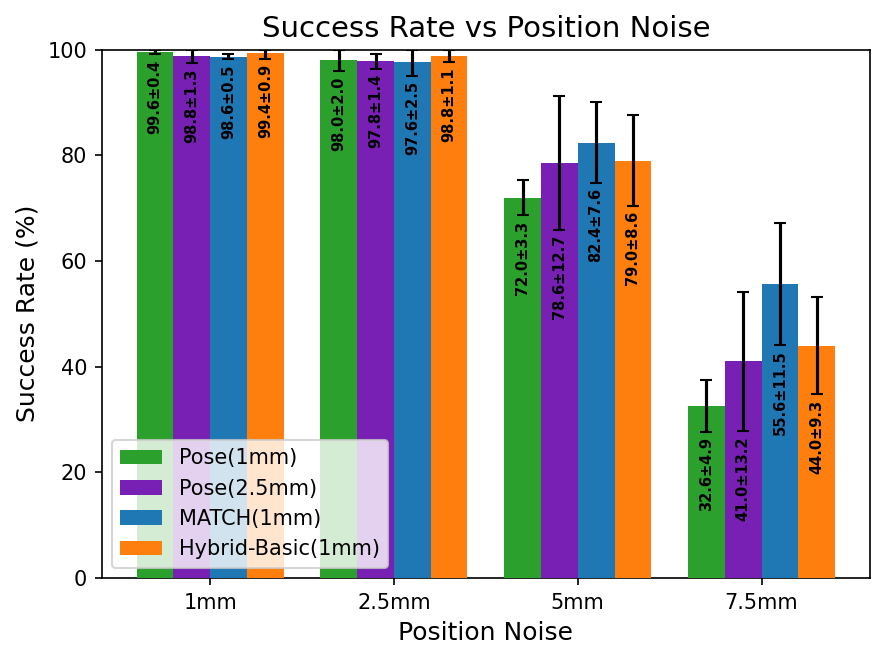

In [18]:
# ============================================================
# BLOCK 4: SUCCESS RATE VS POSITION NOISE
# ============================================================

fig, ax = plot_rate_figure(
    data=noise_data,
    method_names=list(METHOD_TAGS.keys()),
    level_labels=list(NOISE_LEVELS.keys()),
    level_col="noise_level",
    metric="success",
    title="Success Rate vs Position Noise",
    x_label="Position Noise",
    y_label="Success Rate (%)",
    y_lim=SUCCESS_Y_LIM,
    y_ticks=SUCCESS_Y_TICKS,
    error_type=ERROR_TYPE,
    filter_top_n=TOP_N_POLICIES,
    best_checkpoints=best_checkpoints_by_method,
)
plt.show()

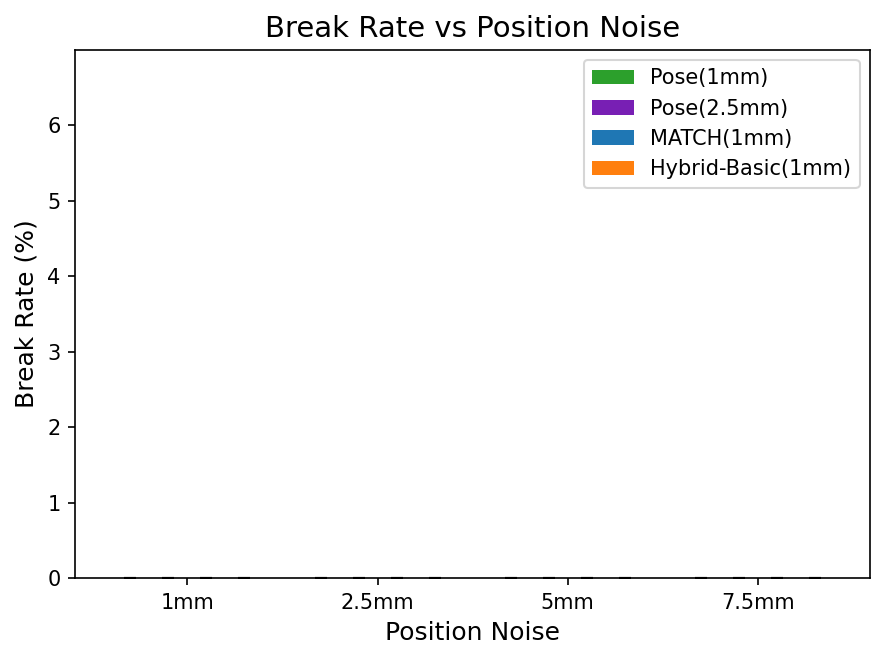

In [19]:
# ============================================================
# BLOCK 5: BREAK RATE VS POSITION NOISE
# ============================================================

fig, ax = plot_rate_figure(
    data=noise_data,
    method_names=list(METHOD_TAGS.keys()),
    level_labels=list(NOISE_LEVELS.keys()),
    level_col="noise_level",
    metric="breaks",
    title="Break Rate vs Position Noise",
    x_label="Position Noise",
    y_label="Break Rate (%)",
    y_lim=BREAK_Y_LIM,
    y_ticks=BREAK_Y_TICKS,
    error_type=ERROR_TYPE,
    filter_top_n=TOP_N_POLICIES,
    best_checkpoints=best_checkpoints_by_method,
)
plt.show()

In [20]:
# ============================================================
# BLOCK 6: LATEX TABLE - NOMINAL PERFORMANCE
# ============================================================

# Table Configuration
TABLE_CAPTION = "Nominal performance on FPiH with round peg at 1mm training noise. Results averaged over 5 seeds. Best performance per metric in \\textbf{bold}."
TABLE_LABEL = "tab:nominal_performance"
DECIMAL_PLACES = 1

# Metrics: (display_name, stat_key, higher_is_better)
TABLE_METRICS = [
    ("Success", "success_rate", True),
    ("Break", "break_rate", False),
    ("Time (s)", "time", False),
    ("Force (N)", "force", False),
]

def format_mean_ci(mean, std, n_seeds, decimal=1):
    """Format mean ± 95% CI (1.96 * SEM)."""
    sem = std / np.sqrt(n_seeds)
    ci = 1.96 * sem
    return f"{mean:.{decimal}f} $\\pm$ {ci:.{decimal}f}"

def bold_if_best(value_str, is_best):
    if is_best:
        return f"\\textbf{{{value_str}}}"
    return value_str

# Compute statistics for each method
stats = {}
for method_name, df in perf_data.items():
    if df.empty:
        continue
    
    # Filter to top N if specified
    if TOP_N_POLICIES is not None:
        df = filter_top_n_runs(df, best_checkpoints_by_method[method_name], TOP_N_POLICIES, match_by="run_id")
    
    df = df.copy()
    df["success_rate"] = 100 * df["success"] / df["total"]
    df["break_rate"] = 100 * df["breaks"] / df["total"]
    df["time"] = df["episode_length"] / 15.0  # Convert to seconds
    df["force"] = df["avg_force_in_contact"]
    
    n_seeds = len(df)
    stats[method_name] = {
        "success_rate": (df["success_rate"].mean(), df["success_rate"].std(), n_seeds),
        "break_rate": (df["break_rate"].mean(), df["break_rate"].std(), n_seeds),
        "time": (df["time"].mean(), df["time"].std(), n_seeds),
        "force": (df["force"].mean(), df["force"].std(), n_seeds),
    }

# Determine best values
best_values = {}
for display_name, stat_key, higher_is_better in TABLE_METRICS:
    means = [(method, stats[method][stat_key][0]) for method in stats]
    if higher_is_better:
        best_method = max(means, key=lambda x: x[1])[0]
    else:
        best_method = min(means, key=lambda x: x[1])[0]
    best_values[stat_key] = best_method

# Generate LaTeX
UP_ARROW = "$\\uparrow$"
DOWN_ARROW = "$\\downarrow$"
header_parts = [f"{m} {UP_ARROW if h else DOWN_ARROW}" for m, _, h in TABLE_METRICS]
header_row = "Method & " + " & ".join(header_parts) + " \\\\"

latex_lines = [
    "\\begin{table}[t]",
    "\\centering",
    f"\\caption{{{TABLE_CAPTION}}}",
    f"\\label{{{TABLE_LABEL}}}",
    "\\begin{tabular}{l" + "c" * len(TABLE_METRICS) + "}",
    "\\toprule",
    header_row,
    "\\midrule",
]

for method_name in METHOD_TAGS.keys():
    if method_name not in stats:
        continue
    
    cells = [method_name]
    for display_name, stat_key, _ in TABLE_METRICS:
        mean, std, n_seeds = stats[method_name][stat_key]
        value_str = format_mean_ci(mean, std, n_seeds, DECIMAL_PLACES)
        is_best = (best_values[stat_key] == method_name)
        cells.append(bold_if_best(value_str, is_best))
    
    latex_lines.append(" & ".join(cells) + " \\\\")

latex_lines.extend([
    "\\bottomrule",
    "\\end{tabular}",
    "\\end{table}",
])

latex_output = "\n".join(latex_lines)
print(latex_output)

\begin{table}[t]
\centering
\caption{Nominal performance on FPiH with round peg at 1mm training noise. Results averaged over 5 seeds. Best performance per metric in \textbf{bold}.}
\label{tab:nominal_performance}
\begin{tabular}{lcccc}
\toprule
Method & Success $\uparrow$ & Break $\downarrow$ & Time (s) $\downarrow$ & Force (N) $\downarrow$ \\
\midrule
Pose(1mm) & 99.4 $\pm$ 0.5 & \textbf{0.0 $\pm$ 0.0} & \textbf{10.0 $\pm$ 0.0} & 2.3 $\pm$ 0.2 \\
Pose(2.5mm) & 75.0 $\pm$ 7.3 & 0.0 $\pm$ 0.0 & 10.0 $\pm$ 0.0 & \textbf{2.1 $\pm$ 0.3} \\
MATCH(1mm) & \textbf{100.0 $\pm$ 0.0} & 0.0 $\pm$ 0.0 & 10.0 $\pm$ 0.0 & 4.4 $\pm$ 0.7 \\
Hybrid-Basic(1mm) & 99.4 $\pm$ 0.8 & 0.0 $\pm$ 0.0 & 10.0 $\pm$ 0.0 & 4.5 $\pm$ 0.9 \\
\bottomrule
\end{tabular}
\end{table}


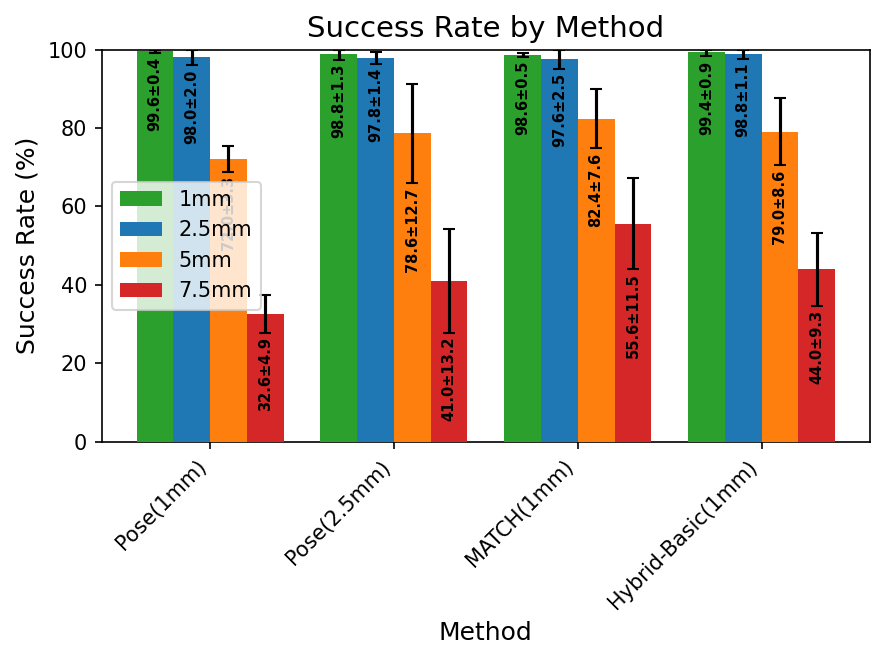

In [21]:
# ============================================================
# BLOCK 7: SUCCESS RATE BY METHOD (NOISE LEVELS AS BARS)
# ============================================================
# Import the new function
from analysis_utils import plot_rate_figure_by_method, NOISE_LEVEL_COLORS

fig, ax = plot_rate_figure_by_method(
    data=noise_data,
    method_names=list(METHOD_TAGS.keys()),
    level_labels=list(NOISE_LEVELS.keys()),
    level_col="noise_level",
    metric="success",
    title="Success Rate by Method",
    x_label="Method",
    y_label="Success Rate (%)",
    y_lim=SUCCESS_Y_LIM,
    y_ticks=SUCCESS_Y_TICKS,
    error_type=ERROR_TYPE,
    level_colors=NOISE_LEVEL_COLORS,
    filter_top_n=TOP_N_POLICIES,
    best_checkpoints=best_checkpoints_by_method,
)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

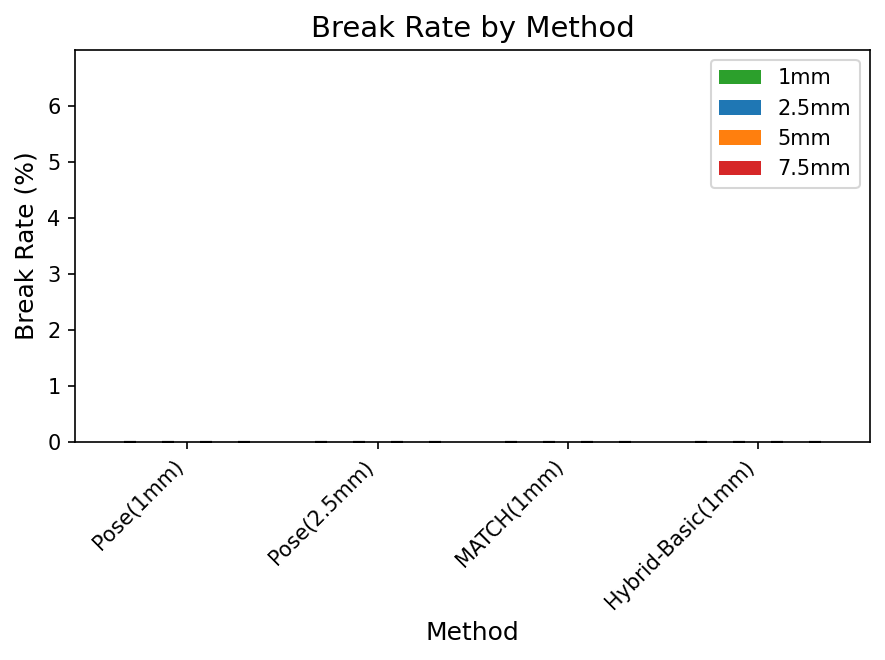

In [22]:
# ============================================================
# BLOCK 8: BREAK RATE BY METHOD (NOISE LEVELS AS BARS)
# ============================================================

fig, ax = plot_rate_figure_by_method(
    data=noise_data,
    method_names=list(METHOD_TAGS.keys()),
    level_labels=list(NOISE_LEVELS.keys()),
    level_col="noise_level",
    metric="breaks",
    title="Break Rate by Method",
    x_label="Method",
    y_label="Break Rate (%)",
    y_lim=BREAK_Y_LIM,
    y_ticks=BREAK_Y_TICKS,
    error_type=ERROR_TYPE,
    level_colors=NOISE_LEVEL_COLORS,
    filter_top_n=TOP_N_POLICIES,
    best_checkpoints=best_checkpoints_by_method,
)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()